In [13]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image, ImageOps 


### Architecture

In [14]:
width = 56
height = 56
depth = 3
latent_space_dim = 16

inputs = Input(shape =(width, height, depth))

x = Conv2D(32, (3, 3), strides=2, padding="same")(inputs)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=-1)(x)

x = Conv2D(64, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=-1)(x)

In [15]:
volumeSize = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_space_dim, name="latent")(x)

latentInputs = Input(shape=(latent_space_dim,))
y = Dense(np.prod(volumeSize[1:]))(latentInputs)
y = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(y)

y = Conv2DTranspose(64, (3, 3), strides=2, padding="same")(y)
y = LeakyReLU(alpha=0.2)(y)
y = BatchNormalization(axis=-1)(y) 

y = Conv2DTranspose(32, (3, 3), strides=2, padding="same")(y)
y = LeakyReLU(alpha=0.2)(y)
y = BatchNormalization(axis=-1)(y)    

y = Conv2DTranspose(depth, (3, 3), padding="same")(y)
outputs = Activation("sigmoid", name="decoded")(y)

#encoder = Model(input = x, outupt = latent)
encoder = Model(inputs, latent, name="encoder")
decoder = Model(latentInputs, outputs, name="decoder")

autoencoder = Model(inputs=inputs, outputs=decoder(encoder(inputs)))
 
    

### Load and prepare MNIST dataset

In [16]:
import os
import cv2

def img_paths(path):
    imgs_path = [os.path.join(path, i) for i in os.listdir(path)]
    imgs_path = [os.path.join(sub_dir, img) for sub_dir in imgs_path for img in os.listdir(sub_dir)]
    return imgs_path

def load_dataset(imgs_path):
    dataset = [np.asarray(Image.open(img_path)) for img_path in imgs_path]
    dataset = np.asarray(dataset)
    return np.take(dataset, np.random.permutation(dataset.shape[0]), axis=0, out=dataset)

def resize_img(img, width, height):
    return cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_AREA)
    
def resize_dataset(dataset, width, height):
    return np.asarray([resize_img(img, width, height) for img in dataset])

In [17]:
imagePathTest = img_paths('dataset/Teste')
imagePathTrain = img_paths('dataset/Traine')

testDataset = load_dataset(imagePathTest)
trainDataset = load_dataset(imagePathTrain)

test = resize_dataset(testDataset,56,56)/255.0
train = resize_dataset(trainDataset,56,56)/255.0

In [18]:
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
#(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)
#autoencoder = ConvAutoencoder.build(28, 28, 1)
#autoencoder = autoencoderModel(28,28,1)
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

[INFO] building autoencoder...


In [19]:
encoder.summary()
decoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 56, 56, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 64)        256 

In [20]:
EPOCHS = 25
BATCH_SIZE = 32

# train the convolutional autoencoder
H = autoencoder.fit(
	train, train,
	validation_data=(test, test),
	epochs=EPOCHS,
	batch_size=BATCH_SIZE)


Train on 67692 samples, validate on 22688 samples
Epoch 1/25
67692/67692 [==============================] - 96s 1ms/sample - loss: 0.0101 - val_loss: 0.0102
Epoch 2/25
67692/67692 [==============================] - 97s 1ms/sample - loss: 0.0058 - val_loss: 0.0060
Epoch 3/25
67692/67692 [==============================] - 97s 1ms/sample - loss: 0.0051 - val_loss: 0.0055
Epoch 4/25
67692/67692 [==============================] - 97s 1ms/sample - loss: 0.0047 - val_loss: 0.0055
Epoch 5/25
67692/67692 [==============================] - 97s 1ms/sample - loss: 0.0044 - val_loss: 0.0052
Epoch 6/25
67692/67692 [==============================] - 95s 1ms/sample - loss: 0.0042 - val_loss: 0.0051
Epoch 7/25
67692/67692 [==============================] - 99s 1ms/sample - loss: 0.0041 - val_loss: 0.0050
Epoch 8/25
67692/67692 [==============================] - 96s 1ms/sample - loss: 0.0040 - val_loss: 0.0050
Epoch 9/25
67692/67692 [==============================] - 97s 1ms/sample - loss: 0.0039 - val_

In [21]:
encoder.save('encoder{}.h5'.format(latent_space_dim))
decoder.save('decoder{}.h5'.format(latent_space_dim))

autoencoder.save('autoencoder{}.h5'.format(latent_space_dim))

recon = autoencoder.predict(test)

In [22]:
ls_dim = 16

autoencoder = tf.keras.models.load_model('autoencoder{}.h5'.format(ls_dim))
encoder = tf.keras.models.load_model('encoder{}.h5'.format(ls_dim))
decoder = tf.keras.models.load_model('decoder{}.h5'.format(ls_dim))


In [23]:
recon = autoencoder.predict(test)

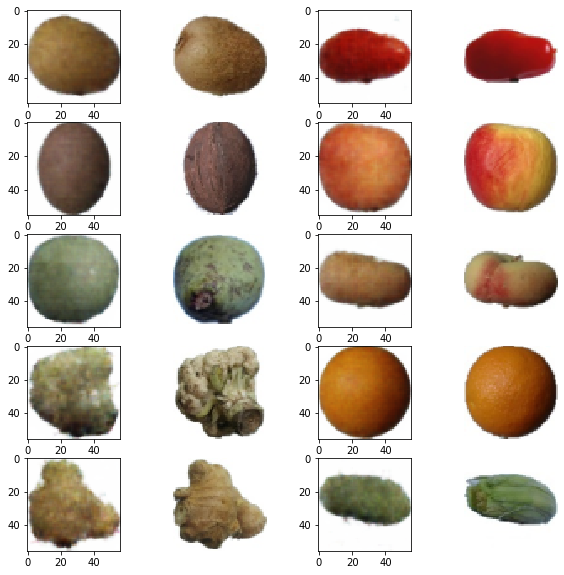

In [24]:
def show_batch(set1, set2, count):
  columns = 4
  rows = count*2 / columns + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(count):
      ax = plt.subplot(rows, columns, n*2+1)
      plt.imshow(set1[n])
      ax = plt.subplot(rows, columns, n*2+2)
      plt.imshow(set2[n])

      plt.axis('off')
        
testXImage = (test * 255).astype("uint8").squeeze() 
reconImage = (recon * 255).astype("uint8").squeeze()
show_batch(reconImage, testXImage, 10)